In [0]:
'''from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!sudo chmod 777 ./prog

# run c program
!./prog

c_mag = pd.read_csv('out.csv', sep=' ').to_numpy()
for i in range(0, len(c_mag)):
  qmad = pq.Quaternion( c_mag[i] )
  qacc = pq.Quaternion([0, acc[i,0], acc[i,1], acc[i,2]])
  qacc_rot = qmad*qacc*qmad.conjugate
  acc_real[i,:] = qacc_rot.elements[1:]
  #acc_real[i,: ] = qmad.rotate(acc[i,:]) 
'''

In [0]:
!pip install pyquaternion
!pip install scikit-kinematics
!pip install numpy-quaternion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pyquaternion as pq
import skinematics as sk
import scipy as sp
import quaternion as nq

In [0]:
%cd /
!wget -O advio21.zip https://zenodo.org/record/1476931/files/advio-21.zip
!unzip advio21.zip
%cd advio-21/iphone/
#!git clone https://github.com/morgil/madgwick_py.git
#!cp ./madgwick_py/quaternion.py ./

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving out_data.csv to out_data.csv
User uploaded file "out_data.csv" with length 195186 bytes


In [0]:
mdg = pd.read_csv('outmad.csv',sep=' ')
gyr = mdg.iloc[:,:3].to_numpy()
acc = mdg.iloc[:,3:6].to_numpy()
mag = mdg.iloc[:,6:9].to_numpy()
leng = np.min([len(gyr),len(acc),len(mag)]) - 1

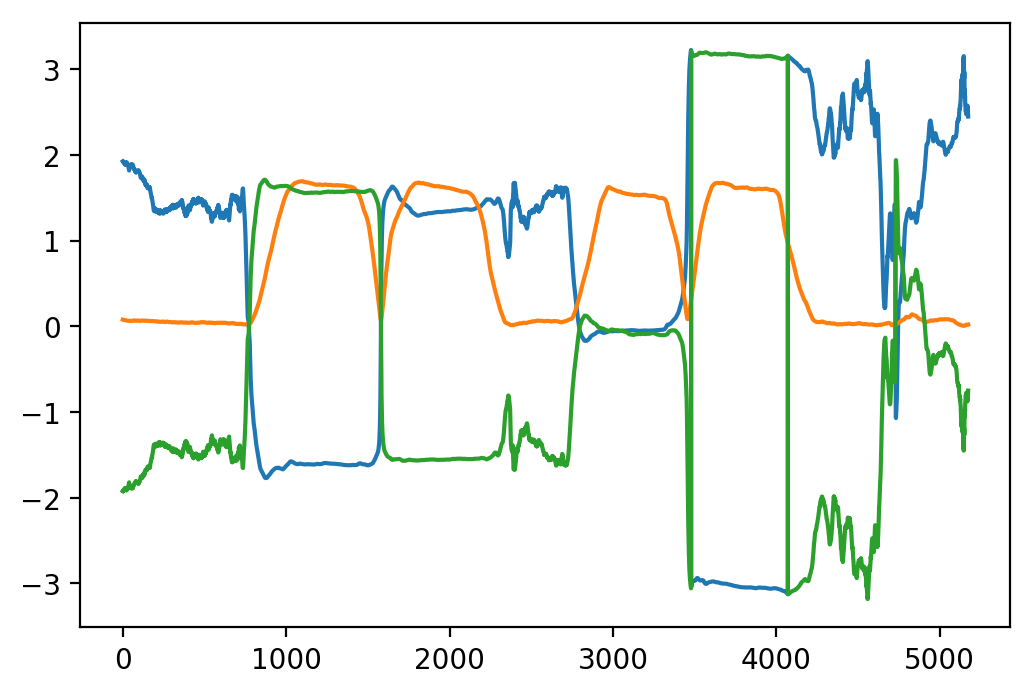

In [0]:
c_mag = pd.read_csv('out_data.csv',sep=' ').to_numpy()
eul= np.zeros((len(c_mag),3))
for i in range(len(c_mag)):
  qmad = nq.from_float_array( c_mag[i] )
  eul[i] = nq.as_euler_angles(qmad) 

plt.figure(dpi=200)
plt.plot(eul[:,0])
plt.plot(eul[:,1])
plt.plot(eul[:,2])

In [0]:
acc = pd.read_csv('accelerometer.csv')
gyr = pd.read_csv('gyro.csv')
mag = pd.read_csv('magnetometer.csv')
leng = np.min([len(gyr),len(acc),len(mag)]) - 1

acc = acc.to_numpy()[:leng,1:]
gyr = gyr.to_numpy()[:leng,1:]
mag = mag.to_numpy()[:leng,1:]

In [0]:
acc_real = np.zeros((leng, 3))
eul = np.zeros((leng, 3))
madg = sk.imus.Madgwick(SamplePeriod=1/256, Beta=.1,  Quaternion=[1, 0, 0, 0])
for i in range(leng):
  madg.Update(gyr[i,:]*np.pi/180, acc[i,:], mag[i,:])
  qmad = nq.from_float_array(madg.Quaternion)
  acc_real[i,:] = nq.as_euler_angles(qmad.conj()*180/np.pi)
  #nqmad = nq.from_float_array(madg.Quaternion)
  #eul[i,:] = nq.as_euler_angles(nqmad) 

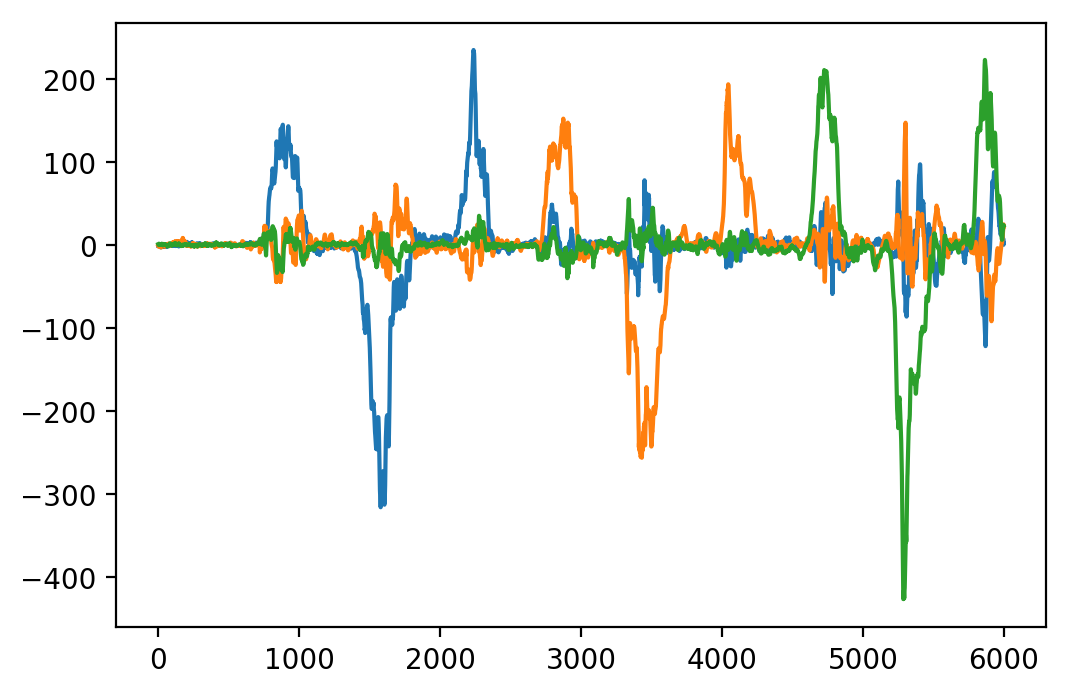

In [0]:
ax = acc_real[:,0]
ay = acc_real[:,1]
az = acc_real[:,2]

x = np.cumsum((acc_real[:,0]))
y = np.cumsum((acc_real[:,1]))
z = np.cumsum((acc_real[:,2]))

plt.figure(dpi=200)
#axs = plt.axes(projection='3d')
plt.plot(gyr[:,0])
plt.plot(gyr[:,1])
plt.plot(gyr[:,2])
axs.view_init(20,70)

In [0]:
acc_kal = np.zeros((leng,3))
q = np.zeros((leng,4))
q = sk.imus.kalman(100,acc,gyr,mag)

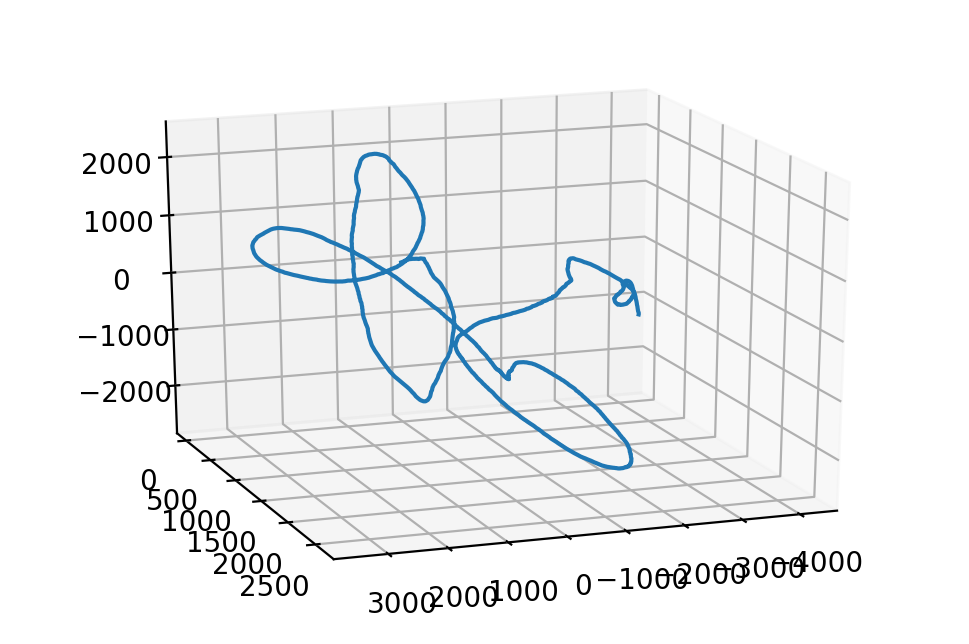

In [0]:
for i in range(leng):
  qkal = pq.Quaternion(q[i])
  acc_kal[i] = qkal.conjugate.rotate(acc[i])

xk = np.cumsum((acc_kal[:,0]))
yk = np.cumsum((acc_kal[:,1]))
zk = np.cumsum((acc_kal[:,2]))  
  
plt.figure(dpi=200)
ax = plt.axes(projection='3d')
plt.plot(xk,yk,zk)
ax.view_init(20,70)

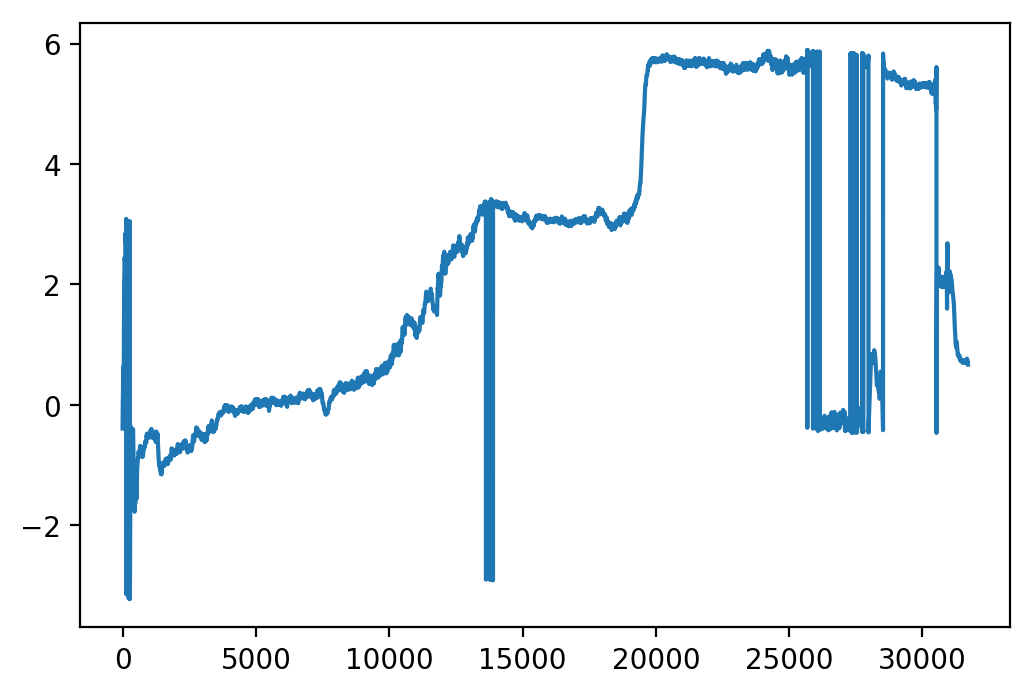

In [0]:
plt.figure(dpi=200)
#ax = plt.axes(projection='3d')
plt.plot(eul[:,0])
#ax.view_init(0,0)

In [0]:
coords = acc_real
# barycenter of the points
# compute centered coordinates
G = coords.sum(axis=0) / coords.shape[0]

# run SVD
u, s, vh = np.linalg.svd(coords - G)

# unitary normal vector
u_norm = vh[2, :]

In [0]:
ahrs = MadgwickAHRS()

for i in range(0, leng):
  ahrs.update(gyr[i,:], acc[i,:], mag[i,:])
  qmad = pq.Quaternion( ahrs.quaternion._get_q() )
  qacc = pq.Quaternion([0, acc[i,0], acc[i,1], acc[i,2]])
  qacc_rot = qmad*qacc*qmad.conjugate
  acc_real[i,:] = qacc_rot.elements[1:]
  #acc_real[i,: ] = qmad.rotate(acc[i,:]) 

acc_real = acc_real[500:,:]
mean=np.mean(acc_real[:,2])
acc_real[:,2] -= 9.81

In [0]:
import warnings
import numpy as np
from numpy.linalg import norm
from quaternion import Quaternion


class MadgwickAHRS:
    samplePeriod = .01
    quaternion = Quaternion(1, 0, 0, 0)
    beta = .07

    def __init__(self, sampleperiod=None, quaternion=None, beta=None):
 
        if sampleperiod is not None:
            self.samplePeriod = sampleperiod
        if quaternion is not None:
            self.quaternion = quaternion
        if beta is not None:
            self.beta = beta

    def update(self, gyroscope, accelerometer, magnetometer):
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()
        magnetometer = np.array(magnetometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Normalise magnetometer measurement
        if norm(magnetometer) is 0:
            warnings.warn("magnetometer is zero")
            return
        magnetometer /= norm(magnetometer)

        h = q * (Quaternion(0, magnetometer[0], magnetometer[1], magnetometer[2]) * q.conj())
        b = np.array([0, norm(h[1:3]), 0, h[3]])

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2],
            2*b[1]*(0.5 - q[2]**2 - q[3]**2) + 2*b[3]*(q[1]*q[3] - q[0]*q[2]) - magnetometer[0],
            2*b[1]*(q[1]*q[2] - q[0]*q[3]) + 2*b[3]*(q[0]*q[1] + q[2]*q[3]) - magnetometer[1],
            2*b[1]*(q[0]*q[2] + q[1]*q[3]) + 2*b[3]*(0.5 - q[1]**2 - q[2]**2) - magnetometer[2]
        ])
        j = np.array([
            [-2*q[2],                  2*q[3],                  -2*q[0],                  2*q[1]],
            [2*q[1],                   2*q[0],                  2*q[3],                   2*q[2]],
            [0,                        -4*q[1],                 -4*q[2],                  0],
            [-2*b[3]*q[2],             2*b[3]*q[3],             -4*b[1]*q[2]-2*b[3]*q[0], -4*b[1]*q[3]+2*b[3]*q[1]],
            [-2*b[1]*q[3]+2*b[3]*q[1], 2*b[1]*q[2]+2*b[3]*q[0], 2*b[1]*q[1]+2*b[3]*q[3],  -2*b[1]*q[0]+2*b[3]*q[2]],
            [2*b[1]*q[2],              2*b[1]*q[3]-4*b[3]*q[1], 2*b[1]*q[0]-4*b[3]*q[2],  2*b[1]*q[1]]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

    def update_imu(self, gyroscope, accelerometer):

        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2]
        ])
        j = np.array([
            [-2*q[2], 2*q[3], -2*q[0], 2*q[1]],
            [2*q[1], 2*q[0], 2*q[3], 2*q[2]],
            [0, -4*q[1], -4*q[2], 0]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion


ModuleNotFoundError: ignored